In [1]:
# imports
import pickle
import glob
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import pandas
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2

%matplotlib inline

In [38]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, ELU
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import Adam
from keras.layers import Lambda


def model(input_shape):
    kernel_size = 3

    model = Sequential()
    
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=input_shape))
    # crop 16 pixels from top and bottom
    #model.add(Cropping2D(cropping=((16,16), (0,0)), input_shape=(160,320,3)))
    model.add(Convolution2D(3,1,1))
    
    model.add(Convolution2D(24,kernel_size,kernel_size))
    model.add(ELU())
    model.add(MaxPooling2D())
    
    model.add(Convolution2D(36,kernel_size,kernel_size))
    model.add(ELU())
    model.add(MaxPooling2D())
    
    model.add(Convolution2D(48,kernel_size,kernel_size))
    model.add(ELU())
    model.add(MaxPooling2D())
    
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(ELU())
    model.add(Dense(128))
    model.add(ELU())
    model.add(Dense(64))
    model.add(ELU())
    model.add(Dense(16))
    model.add(ELU())
    model.add(Dense(8))
    model.add(ELU())
    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='Adam', lr=1e-4)
    return model
    
m = model((32,32,3))  

In [3]:
def plot_images(images, label, n_cols=5):
    """
    plot images in n_cols columns
    :param images 
    :param label image labels
    :param n_cols number of columns
    """
    
    n_rows = math.ceil(len(images)/n_cols)
 
    plt.figure(figsize=(n_rows*20, n_cols*2))   
    for i,image in enumerate(images):
        image = image.squeeze()
        plt.subplot(n_rows, n_cols, i+1)  
        plt.title("Output " + str(label[i]))
        plt.imshow(image)
    plt.show()
    
def plot_histogram(labels, n_labels):
    """
    Exploration of the label distribution
    """
    plt.hist(labels, n_labels)
    plt.xlabel('Labels')
    plt.ylabel('Label Count')
    plt.title('Histogram')
    plt.show()    

In [4]:

# Using opencv functions to make Geometric Transformations
# http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html
def translate(image, tx=0, ty=0):
    '''
    Translate/Shift an image by (tx, ty) 
    '''
    # Translation matrix
    M = np.float32([[1,0,tx],[0,1,ty]])    
    return cv2.warpAffine(image,M,image.shape[0:2])

def rotate(image, angle=0):
    '''
    Rotate image by angle in degrees
    '''
    rows,cols = image.shape[0:2]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    return cv2.warpAffine(image,M,image.shape[0:2])

def scale(image, factor=1.0):
    '''
    Scale image by factor
    '''
    rows,cols = image.shape[0:2]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),0,factor)    
    return cv2.warpAffine(image,M,image.shape[0:2])

def brighten(image, factor=1.0):
    '''
    Change brightness of image by factor
    '''
    image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image[:,:,2] = image[:,:,2] * factor
    return cv2.cvtColor(image,cv2.COLOR_HSV2RGB)

def flip(image):
    '''
    Flip image left to right
    '''
    return cv2.flip(image,1)

def blur(image, kernel=5):
    '''
    
    '''
    return cv2.medianBlur(image,kernel)
    
def sharpen(image):
    '''
    
    '''
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    return cv2.filter2D(image, -1, kernel)



In [5]:
def generate_random_images(X,y):
    """
    Generate augmented images randomly
    """
    unique, unique_idx, unique_counts = np.unique(y, return_index=True, return_counts=True)
    max_count = np.max(unique_counts)

    for image, label in zip(X,y):        
        n_to_generate = int(max_count/unique_counts[label])
        for i in range(0,n_to_generate,5):
            image_aug = (translate(image, np.random.uniform(-5,5),np.random.uniform(-5,5)))
            yield image_aug,label 
            image_aug = (rotate(image,np.random.uniform(-10,10)))
            yield image_aug,label 
            image_aug = (scale(image,np.random.uniform(0.8,1.2)))
            yield image_aug,label   

In [6]:
### Preprocess the data here.
# Implement Min-Max scaling for color image data
def normalize_color(image_data):
    """
    Normalize the image data with scaling to a range of [-0.5, 0.5]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    return image_data/255.0 - 0.5

In [13]:
path = './data/'
correction = 0.2
df_cars = pandas.read_csv(path + 'driving_log.csv')

print("Number of images:", len(df_cars))


Number of images: 8036


In [ ]:


images = []
steerings = []
labels = []
for idx, row in df_cars.iterrows():
    img_center = np.asarray(plt.imread(path + row['center']))
    img_center = process_image(img_center)

    img_left = plt.imread(path + row['left'].replace(' ', ''))
    img_right = plt.imread(path + row['right'].replace(' ', ''))
    #images.append(img_center)
    steering_center = np.float32(row['steering'])
    steering_left = steering_center + correction
    steering_right = steering_center - correction
    steerings.append(steering_center)
    labels.append(np.sign(steering_center))

    
    


Image shape  (32, 64, 3)
<class 'numpy.ndarray'>


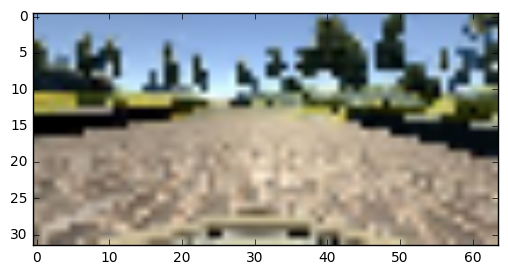

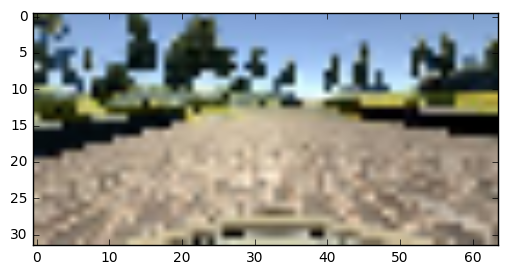

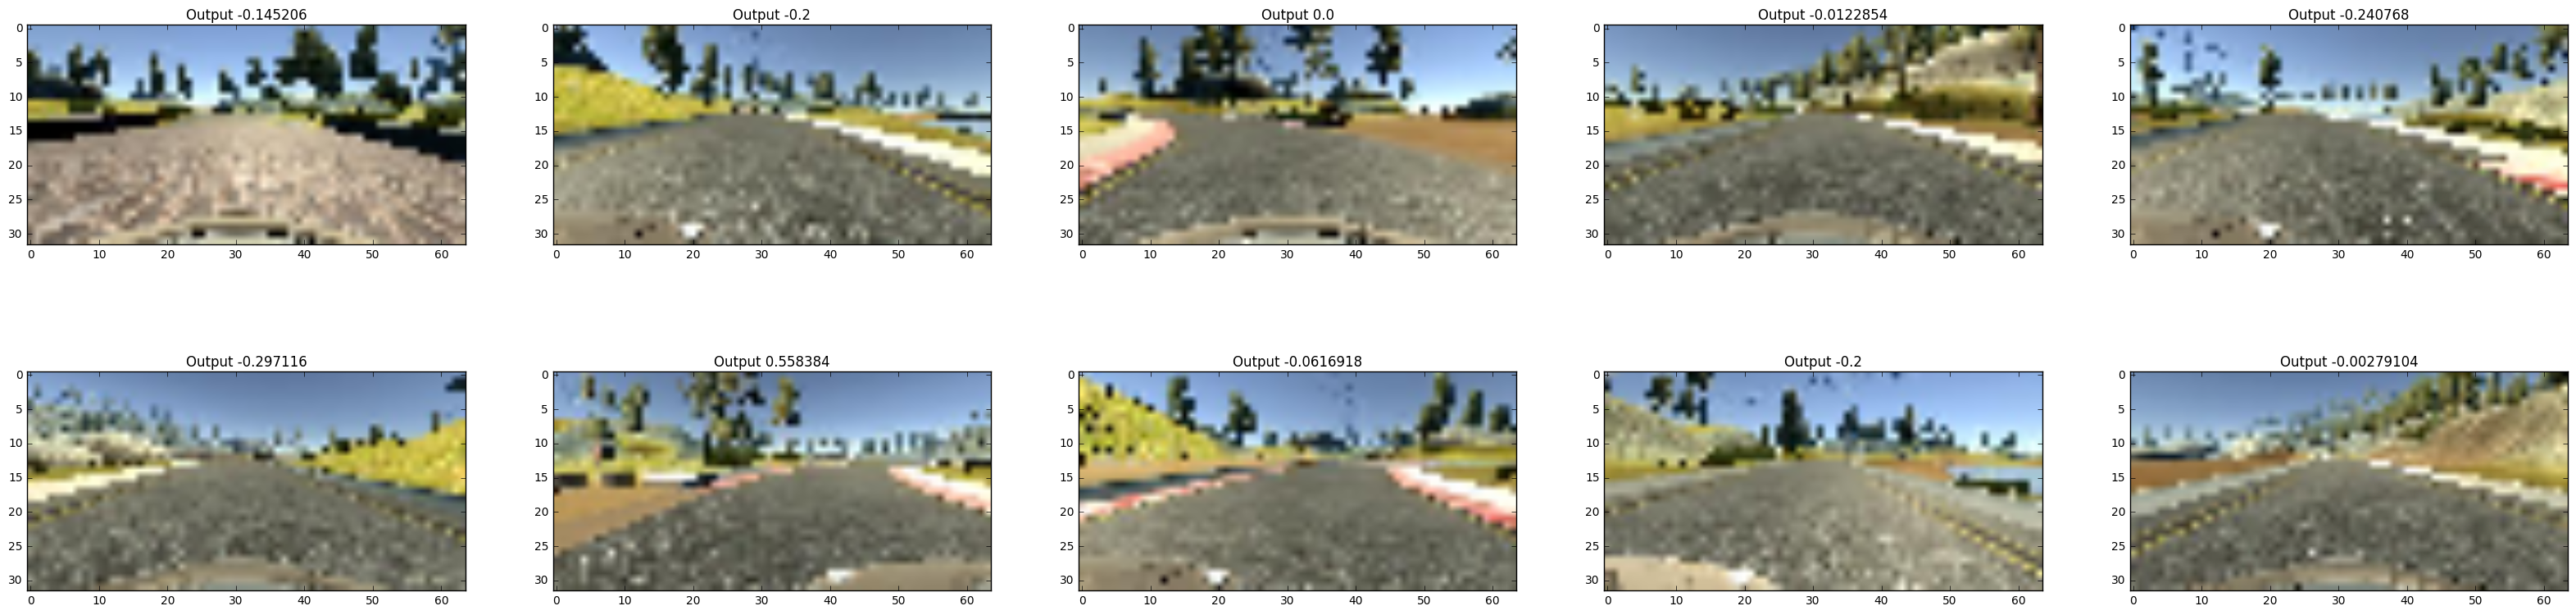

In [59]:
def augment_image(image):
    '''
    '''
    image = cv2.resize(image, (64,32))
    image = np.array(image)
    return image

def image_gen(batch_size, normalize=False, augment=True):
    '''
    generator for a random batch with original and augmented data
    :param batch_size
    '''
    df = df_cars.sample(batch_size)
    batch_images = []
    batch_steerings = []
    batch_labels = []
    cameras = ['left' ,'center', 'right']
    correction = [0.2, 0., -0.2]
    while True:        
        for idx, row in df.iterrows():
            #img_center = np.asarray(plt.imread(path + row['center']))

            # select left,right,center camera randomly
            cam_idx = np.random.randint(3)
            camera = cameras[cam_idx]
            # read images, there are some wrong spaces in the file strings
            image = plt.imread(path + row[camera].replace(' ', ''))
            if augment:
                image = augment_image(image)
            if normalize:
                image = normalize_color(image)
                
            steering = np.float32(row['steering'] + correction[cam_idx] )
            label = np.sign(steering) 

            batch_labels.append(label)
            batch_images.append(image)
            batch_steerings.append(steering)
        yield np.array(batch_images), np.array(batch_steerings)

example_images, example_steerings= next(image_gen(10, normalize=False))


print("Image shape ", example_images[0].shape)
assert(len(example_images) == len(example_steerings))
print(type(example_images))
plt.imshow(example_images[0])
plt.show()
plt.imshow(flip(example_images[0]))
plot_images(example_images, example_steerings)


In [62]:
N_EPOCHS = 5
BATCH_SIZE = 256
input_shape=(32,64,3)


m = model(input_shape)
m.fit_generator(image_gen(batch_size=BATCH_SIZE), \
                samples_per_epoch=256*50, \
                nb_epoch=N_EPOCHS, \
                validation_data=image_gen(batch_size=1, augment=True), \
                nb_val_samples=400)
m.save('model.h5')

/usr/local/lib/python3.4/dist-packages/keras/backend/tensorflow_backend.py:1057: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Epoch 1/5
11520/12800 [==========================>...] - ETA: 3s - loss: 0.0378

/usr/local/lib/python3.4/dist-packages/keras/engine/training.py:1480: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


14080/12800 [=================================] - 34s - loss: 0.0366 - val_loss: 0.0130
Epoch 2/5
12800/12800 [==============================] - 29s - loss: 0.0276 - val_loss: 0.0115
Epoch 3/5
16896/12800 [=======================================] - 38s - loss: 0.0247 - val_loss: 0.0113
Epoch 4/5
15360/12800 [====================================] - 34s - loss: 0.0230 - val_loss: 0.0126
Epoch 5/5
17664/12800 [=========================================] - 39s - loss: 0.0210 - val_loss: 0.0049
